# Performance analysis at system-level

## Database connection
Establish connection to neo4j database with performance data.

In [36]:
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password = 'neo4j')


## Cypher query
Cypher queries are executed to get CPU and memory utilization data. The results are stored in dataframes.

In [37]:
import pandas as pd

# one query each for CPU and memory
cpu_query = """
MATCH (r:Record)-[:CONTAINS]->(c:CpuUtilization)
WHERE r.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN c.timestamp AS timestamp, c.cpuID AS cpuID, c.totalUtilization * 100 AS cpuUtilization
ORDER BY timestamp
"""
df = pd.DataFrame(graph.run(cpu_query).data())
# drop first and last measurements to sanitize data
df.drop(df.head(3).index, inplace=True)
df.drop(df.tail(5).index, inplace=True)
print(df.head())

mem_query = """
MATCH (r:Record)-[:CONTAINS]->(m:MemSwapUsage)
WHERE r.fileName =~ '.*/1-MemoryLeak-5/kieker-logs/kieker-20150820-064855519-UTC-middletier2-KIEKER'
RETURN m.timestamp AS timestamp, toFloat(m.memUsed)*100.0 / toFloat(m.memTotal) AS memoryUtilization
ORDER BY timestamp
"""
df_mem = pd.DataFrame(graph.run(mem_query).data())
# drop first and last measurements to sanitize data
df_mem.drop(df_mem.head(3).index, inplace=True)
df_mem.drop(df_mem.tail(5).index, inplace=True)

             timestamp cpuID  cpuUtilization
3  1440053345612101780     1       24.261603
4  1440053355611996675     0        3.600000
5  1440053355612055040     1        4.609218
6  1440053365611980343     0        0.500501
7  1440053365612037995     1        0.800801


## Analysis and Visualization
The data is analyzed, merged and visualized. The timestamps only differ in the microseconds.

They are rounded to the nearest second to allow the merge of the dataframes.

In [38]:
# round up to the nearest second to later merge the dataframes
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.round('1s')
df['CPU ID'] = pd.to_numeric(df['cpuID'])
# get the mean utilization of every CPU core
df = df.groupby(['timestamp']).mean()
df = df.drop('CPU ID', 1)

df_mem['timestamp'] = pd.to_datetime(df_mem['timestamp'])
df_mem['timestamp'] = df_mem['timestamp'].dt.round('1s')
df_mem.set_index('timestamp', inplace=True)

# merge the dataframes
df = df.merge(df_mem, left_on='timestamp', right_on='timestamp')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                     cpuUtilization  memoryUtilization
timestamp                                             
2015-08-20 06:49:26        0.650651          41.020209
2015-08-20 06:49:36        0.949251          41.007907
2015-08-20 06:49:46        1.002306          41.007490
2015-08-20 06:49:56        7.204219          41.163040
2015-08-20 06:50:06        1.151151          41.151155
2015-08-20 06:50:16        0.800501          41.167836
2015-08-20 06:50:26        0.700401          41.157619
2015-08-20 06:50:36        0.601404          41.158661
2015-08-20 06:50:46        0.851655          41.153657
2015-08-20 06:50:56        0.750601          41.158244
2015-08-20 06:51:06        0.749551          41.159495
2015-08-20 06:51:16        0.750450          41.184100
2015-08-20 06:51:26        0.550000          41.184517
2015-08-20 06:51:36        0.901956          41.190981
2015-08-20 06:51:46        0.801403          41.192232
2015-08-20 06:51:56        0.800601          41.185351
2015-08-20

In [39]:
df.head()

,cpuUtilization,memoryUtilization
timestamp,,
2015-08-20 06:49:26,0.650651,41.020209
2015-08-20 06:49:36,0.949251,41.007907
2015-08-20 06:49:46,1.002306,41.007490
2015-08-20 06:49:56,7.204219,41.163040
2015-08-20 06:50:06,1.151151,41.151155


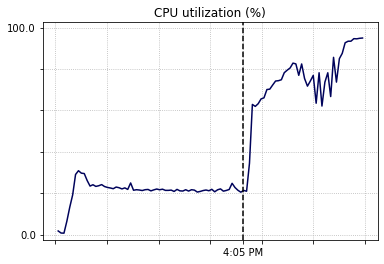

In [40]:
import matplotlib.pyplot as plt

# get the average of 7 measurements to sanitize the data
df_cpu_plot = df.rolling(7).mean()
df_cpu_plot = df_cpu_plot.iloc[::7, :]

# label and style the plot
plt.plot_date(df_cpu_plot.index, df_cpu_plot['cpuUtilization'], fmt='-', color='#00035b')
plt.title('CPU utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

# fill in the data
date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
# As we don't know the time zone, we choose the time that makes the most sense
plt.xticks(date_list + ['2015-08-20 08:05'], ['', '', '', '', '', '', '', '4:05 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 08:05', color='black', label='4:05 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# uncomment to save the plot as a pdf
# plt.savefig('cpu_plot.pdf')
plt.show()

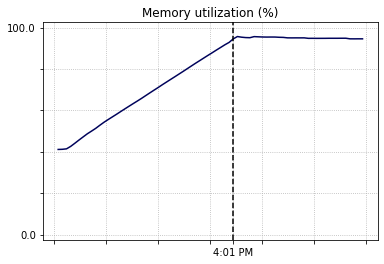

In [41]:
# get the average of 7 measurements to sanitize the data
df_mem_plot = df.rolling(10).mean()
df_mem_plot = df_mem_plot.iloc[::10, :]

# label and style the plot
plt.plot_date(df_mem_plot.index, df_mem_plot['memoryUtilization'], fmt='-', color='#00035b')
plt.title('Memory utilization (%)')
plt.ylim(-2.5, 102.5)
plt.grid(linestyle=':')

# fill in the data
date_list = pd.date_range(start=df.index[0], end=df.index[-1], periods=7).tolist()
plt.xticks(date_list + ['2015-08-20 08:01'], ['', '', '', '', '', '', '', '4:01 PM'])
plt.yticks([0.0, 20.0, 40.0, 60.0, 80.0, 100.0], ['0.0', '', '', '', '', '100.0'])
plt.axvline('2015-08-20 08:01', color='black', label='4:01 PM', linestyle='--')
plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 0)
# uncomment to save the plot as a pdf
# plt.savefig('mem_plot.pdf')
plt.show()